# Set-up

In [1]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import pickle
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


# Constantes et fonctions

In [87]:
REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'
DICT_COLS = {'Title': 100, 'Body': 450}
SAMPLE = 5000
RATIO = 1/3

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
EXTRA_SW = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb', 'without', 'behind', \
            'within')

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = tknzr.tokenize(unidecode.unidecode(col).lower())
    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in temp if w not in sw and not w.isdigit())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def tag_question(title, body):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """ 

    RATIO = 1/3
    REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

    # Stopwords nltk 
    std_sw = set(nltk.corpus.stopwords.words('english')) 

    # Extra stopwords = radicaux qui ne me semblent pas discriminants 
    extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
                'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
                'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


    tokenizer = nltk.RegexpTokenizer(REGEX)
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    with open('OC_DS_P6_prod.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        sclr = unpickler.load()
        tfidf = unpickler.load()
        mod = unpickler.load()
        lbl = unpickler.load()

    title = clean_field(title, tknzr=tokenizer, sw=std_sw, \
                        lmtzr=lemmatizer, stmr=stemmer)
    title = ' '.join([w for w in title.split() \
                       if w not in extra_sw and not w.isdigit()])

    body = clean_field(body, tknzr=tokenizer, sw=std_sw, \
                       lmtzr=lemmatizer, stmr=stemmer)
    body = ' '.join([w for w in body.split() \
                      if w not in extra_sw and not w.isdigit()])
    
    tfidf_q = tfidf['Title'].transform([title])
    cols = tfidf['Title'].get_feature_names()
    tfidf_q = pd.DataFrame(tfidf_q.todense().tolist(), columns=cols)

    tfidf_b = tfidf['Body'].transform([body])
    cols = tfidf['Body'].get_feature_names()
    tfidf_b = pd.DataFrame(tfidf_b.todense().tolist(), columns=cols)

    X = (RATIO * tfidf_q).add((1 - RATIO) * tfidf_b, fill_value=0).fillna(0)

    return '<{}>'.format('><'.\
                         join(lbl.inverse_transform(mod.predict(sclr.transform(X))).\
                                                    split()))

# Chargement

In [8]:
with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    source = unpickler.load()

# Etiquetage des tags
lbl = LabelEncoder()
source['Tags_lbl'] = lbl.fit_transform(source.Tags)

In [9]:
source.head()

,Title,Body,Tags,nTags,full,Tags_lbl
169828,benefit studio team system databas edit,anyon vst databas edit featur standard studio ...,database-tools sql-server,2,benefit studio team system databas edit gdr an...,22152
431644,hook formsauthenticationmodul medium trust env...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5,hook formsauthenticationmodul medium trust env...,8112
1450121,sync algorithm refer directori,plan write program sync folder time across mul...,algorithm synchronization,2,sync algorithm refer directori plan write prog...,5236
426609,assign profil valu,profil properti web config file cannot access ...,asp.net asp.net-membership asp.net-mvc profile,4,assign profil valu profil properti web config ...,7373
14646,project descript fogbugz,project edit sampl project descript project blind,fogbugz,1,project descript fogbugz project edit sampl pr...,26437


In [10]:
source.nTags.value_counts().to_frame().sort_index()

,nTags
1,5512
2,13722
3,15367
4,10228
5,5171


In [11]:
train = source.sample(10000)
len(train.Tags.unique())

8266

# TF-IDF
Je crée un dictionnaire avec les vecteurs TFIDF pour les appeler dans la fonction finale

In [88]:
dict_tfidf = defaultdict(dict)

for col in ['Title', 'Body']:
    X = train[col].copy()

    dict_tfidf['vector'][col] = TfidfVectorizer(token_pattern=REGEX, \
                                                stop_words=EXTRA_SW, \
                                                min_df=DICT_COLS[col]).fit(X)
    v_tfidf = dict_tfidf['vector'][col].transform(X)
    cols = dict_tfidf['vector'][col].get_feature_names()
    dict_tfidf['df'][col] = pd.DataFrame(v_tfidf.todense().tolist(), \
                                         columns=cols, index=train.index)
    print(col, ':', dict_tfidf['df'][col].shape)
    print(cols)

Title : (10000, 71)
['access', 'app', 'applic', 'array', 'asp', 'c', 'c#', 'c++', 'call', 'chang', 'class', 'code', 'column', 'control', 'custom', 'data', 'databas', 'differ', 'element', 'error', 'event', 'file', 'form', 'function', 'gener', 'git', 'html', 'imag', 'java', 'javascript', 'jqueri', 'key', 'linq', 'list', 'method', 'multipl', 'mvc', 'mysql', 'name', 'net', 'number', 'object', 'one', 'page', 'paramet', 'php', 'problem', 'project', 'properti', 'python', 'queri', 'return', 'script', 'server', 'servic', 'set', 'sql', 'string', 'studio', 'system', 'tabl', 'text', 'time', 'type', 'user', 'v', 'valu', 'web', 'window', 'work', 'xml']
Body : (10000, 92)
['access', 'anoth', 'answer', 'anyon', 'app', 'applic', 'build', 'c', 'c#', 'call', 'case', 'chang', 'check', 'class', 'code', 'contain', 'control', 'data', 'databas', 'e', 'edit', 'error', 'etc', 'everi', 'exampl', 'file', 'fine', 'form', 'found', 'function', 'help', 'idea', 'implement', 'issu', 'java', 'line', 'list', 'look', 'mea

# Clustering

## Title

### PCA

In [89]:
pca = decomposition.PCA(n_components=2)

X = dict_tfidf['df']['Title']

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.02434238 0.02044855] 0.04479093773046337


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (2668) found smaller than n_clusters (3000). Possibly due to duplicate points in X.
  


best clustering =  2500 elapsed :  426.6720134080001


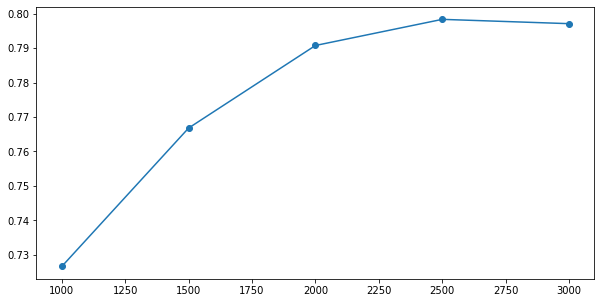

In [70]:
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(1000, 3500, 500)

start_time = timeit.default_timer()
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, myclust.labels_))

elapsed = timeit.default_timer() - start_time
best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster, 'elapsed : ', elapsed)

fig = plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouettes, marker='o')

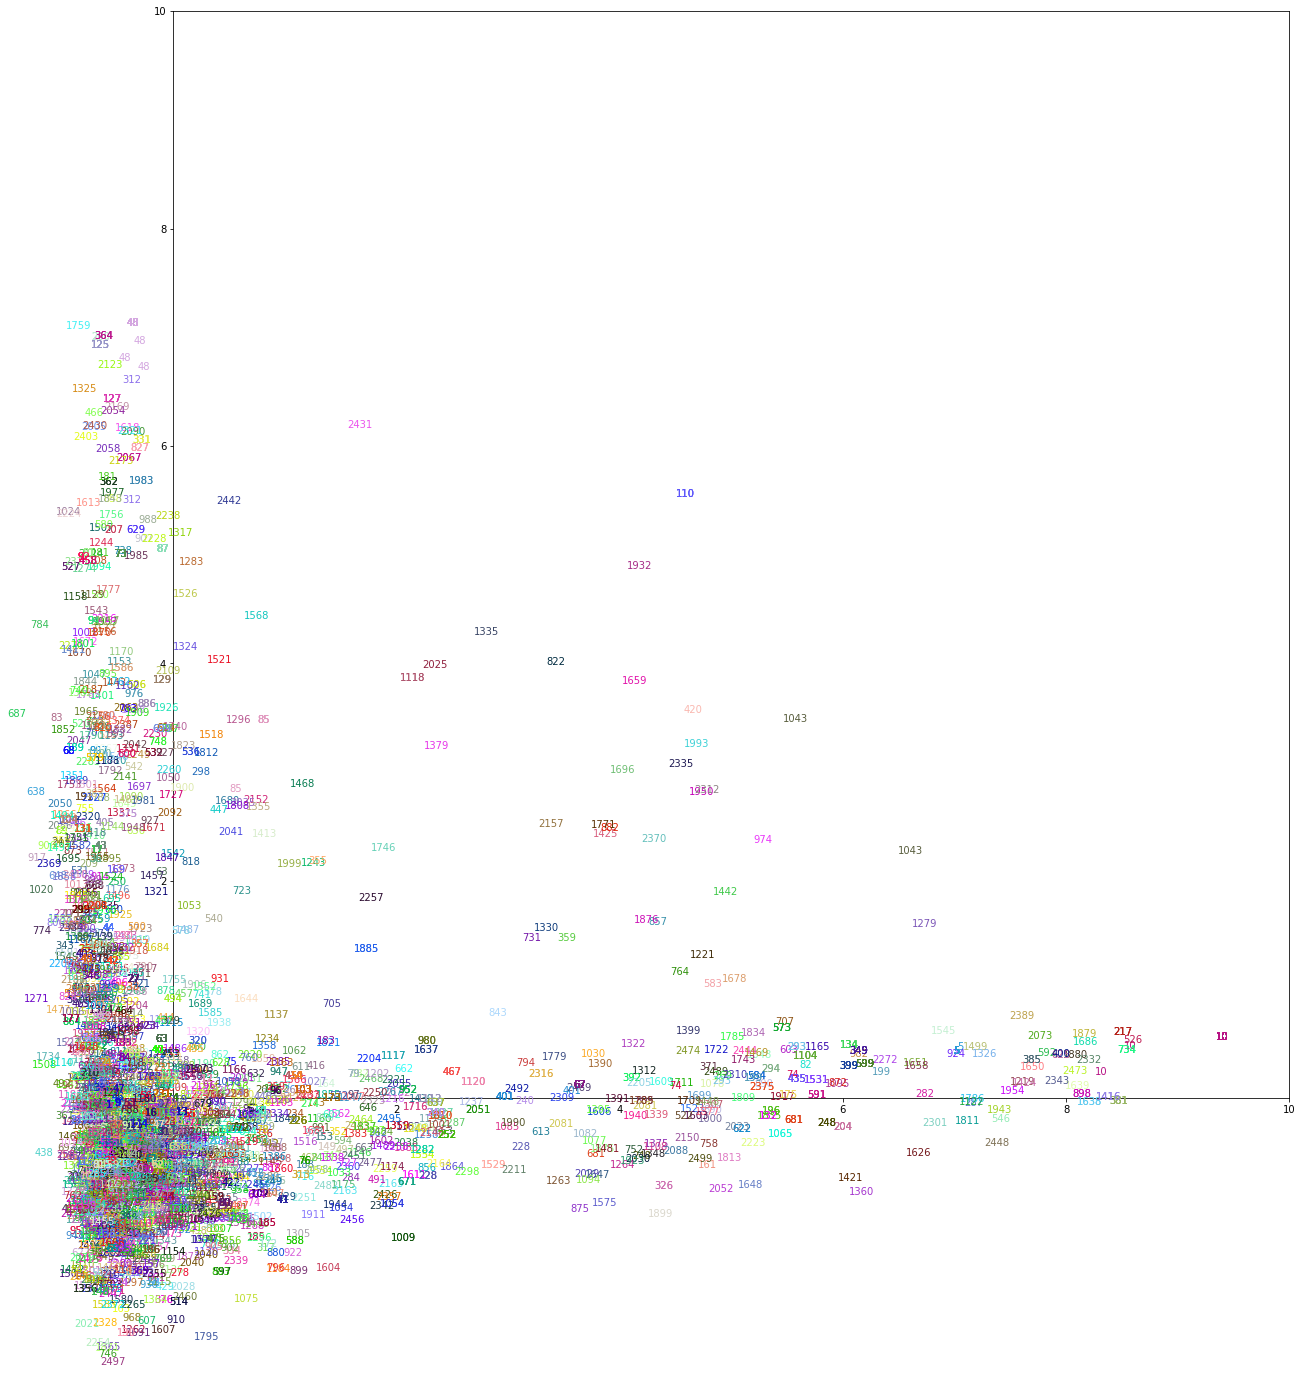

Silhouette Coefficient: 0.796


In [71]:
nb_clusters = best_cluster
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [72]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['df']['Title'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,2,101,2619,28,57,43,44,58,36,104,29,42,53,39,95,77,50,22,25,45,43,37,41,41,34,25,172,35,43,1,27,87,28,83,27,39,39,122,53,76,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [73]:
tfidf[tfidf.cluster == 3][['cluster']].merge(train[['Title', 'Body', 'Tags']], left_index=True, right_index=True)

,cluster,Title,Body,Tags
175109,3,regist custom log4net,log4net found interfac u control type provid i...,c# log4net
41853933,3,ec2 instanc custom pass limit,amazon ec2 instanc stop custom pass limit arti...,amazon-cloudwatch amazon-s3 amazon-web-services
389331,3,schedul custom action immedi custom action wix,statement effect refer immedi custom action wx...,custom-action dtf windows-installer wix
535314,3,practic custom involv agil develop,involv custom develop partner develop process ...,agile collaboration communication
1134986,3,custom wpf collect,custom set class wpf control xaml problem item...,.net collections wpf xaml
2502822,3,custom cell,overridden tableview method class thought oper...,iphone uitableview
275603,3,guidelin custom tool,product tool test uniqu featur diagnos problem...,standards
786884,3,tutori develop custom eclips editor,learn editor eclips languag tutori help topic ...,eclipse editor java
9559501,3,custom uitableviewcel,custom uitableviewcel control inform row tabl ...,uitableview xamarin.ios
640463,3,custom iprincip,asp net window authent custom iprincip object ...,asp.net authentication windows-authentication


## Quote-part Title et Body


In [74]:
X = (RATIO * dict_tfidf['df']['Title']).add((1 - RATIO) * dict_tfidf['df']['Body'], \
                                            fill_value=0).fillna(0)

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### PCA

In [75]:
pca = decomposition.PCA(n_components=2)
X_trans = pca.fit_transform(X_scaled)
print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.01484834 0.01466632] 0.029514664278530844


best clustering =  7500 elapsed :  2556.2136118239996


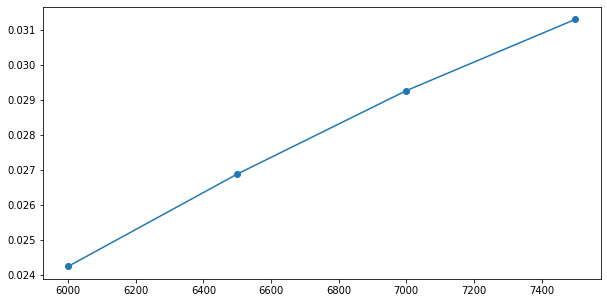

In [78]:
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(6000, 8000, 500)

start_time = timeit.default_timer()
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, myclust.labels_))

elapsed = timeit.default_timer() - start_time
best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster, 'elapsed : ', elapsed)

fig = plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouettes, marker='o')

In [ ]:
nb_clusters = best_cluster

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

Silhouette Coefficient: 0.972


In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['df']['Title'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,8491,3,1,1,3,3,1,1,1,1,1,2,1,1,1,1,2,2,1,2,1,1,1,10,1,1,1,1,2,1,2,2,1,1,2,1,6,1,2,1,...,2,4,1,1,3,2,1,1,2,2,2,1,1,1,1,2,3,3,1,3,2,1,2,1,1,2,4,1,1,1,1,1,2,1,1,1,1,1,1,1


In [ ]:
tfidf[tfidf.cluster == 23][['cluster']].merge(train[['Title', 'Body', 'Tags']], left_index=True, right_index=True)

,cluster,Title,Body,Tags
186237,23,program crash releas build debug,cat type problem program test suit program pro...,c++ debugging
2422949,23,implic gener list list,dao contain class gener us arraylist store obj...,arraylist generic-list generics java
220824,23,root mysteri charact problem wordpress blog,start wordpress blog charact browser other quo...,encoding utf-8 wordpress
2958817,23,cannot access object within method custom jsp ...,custom jsp tag everyth fine except fact reques...,custom-tags java jsp
2155065,23,forc exit one depend fail,relev bit makefil makefil compil error debugos...,gcc gnu-make makefile
1455059,23,item level secur sharepoint webservic,permiss list site permiss paramet accept eithe...,permissions sharepoint sharepoint-2007
10006,23,compress wcf silverlight,silverlight beta applic access wcf web servic ...,compression gzip silverlight wcf
971586,23,asp net method found,problem product server cannot two strang thing...,asp.net constructor exception vb.net
602991,23,scope mean exist,sure understand scope out-of scope rubi exist ...,ruby scope variables
331717,23,compon password joomla,chang default behavior joomla password mechan ...,joomla php


# Classification supervisée

In [94]:
DICT_CLF = {'knn': {'name': 'k-Nearest Neighbors',
                     'clf': KNeighborsClassifier(),
                     'params': {'n_neighbors': np.arange(100, 700, 50)}},
            'rfc': {'name': 'Random Forrest',
                     'clf': RandomForestClassifier(),
                     'params': {'criterion': ['entropy', 'gini'],
                                'n_estimators': [20, 40, 60, 80, 100],
                                'max_features':['sqrt', 'log2']}}
            }

In [ ]:
            'svm': {'name': 'Support Vector Machine',
                     'clf': LinearSVC(dual=False, multi_class='ovr') ,
                     'params': {'C': np.logspace(-3, 3, 7),
                                'loss': ['hinge','squared_hinge'],
                                'penalty': ['l1', 'l2']}},


## Title

In [91]:
train.shape

(10000, 6)

In [ ]:
col = 'Title'

y = train.Tags_lbl
X = train[col]
X_train, X_test, y_train, y_test = train_test_split(dict_tfidf[col]['vector'].\
                                                    transform(X), y, \
                                                    test_size=0.3)

std_scale = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3858, 300), (1654, 300))

In [85]:
dict_precision = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision[v['name']] = {}

    clf = v['clf']
    start_time = timeit.default_timer()
    gs = GridSearchCV(clf, v['params'], cv=5, scoring = 'accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_precision[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    elapsed = timeit.default_timer() - start_time

    accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    print(col, ": accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

k-Nearest Neighbors
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best params: {'n_neighbors': 300} 

Precision: 3.00 % 

Body : accuracy 3.00% time 120.14s

Support Vector Machine
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: ignored

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print(col, "accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

Title accuracy 41.00% time 11.21s



## Title + Body

In [92]:
X = (RATIO * dict_tfidf['df']['Title']).add((1 - RATIO) * dict_tfidf['df']['Body'], \
                                            fill_value=0).fillna(0)
y = train.Tags_lbl
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=0.3)

std_scale = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((7000, 119), (3000, 119))

In [96]:
dict_precision = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision[v['name']] = {}

    clf = v['clf']
    start_time = timeit.default_timer()

    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)

    elapsed = timeit.default_timer() - start_time

    print("Best params:", gs.best_params_, 'elapssed : ', elapsed)
    dict_precision[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    """
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                             # display_labels=class_names,
                                             cmap=plt.cm.Blues, \
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()
    """
    print()

k-Nearest Neighbors
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best params: {'n_neighbors': 350} elapssed :  100.71628917599992
Precision: 2.00 % 


Random Forrest
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
exception calling callback for <Future at 0x7f799f438e10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._

TerminatedWorkerError: ignored

# LDA

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern=REGEX,  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Title)
data_vectorized.shape

In [ ]:
#instantiate CountVectorizer() 
cv = CountVectorizer()
 
# this steps generates word counts for the words in your docs 
TF = cv.fit_transform(train.Title, train.Body)

In [ ]:
TF

<10000x3573 sparse matrix of type '<class 'numpy.int64'>'
	with 38866 stored elements in Compressed Sparse Row format>


        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0

In [ ]:
params = {'n_components' : np.arange(500, 5000, 500), 'learning_decay': [.5, .7, .9]}
clf = LatentDirichletAllocation()

print('{}\n{}\n{}'.format('='*30, 'lda', '-'*30))
dict_precision["lda"] = {}

gs = GridSearchCV(clf, params)
gs.fit(TF)

print("Best params:", gs.best_params_, '\n')
dict_precision["lda"]['clf'] = gs

lda
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_ld

Best params: {'learning_decay': 0.5, 'n_components': 10} 



In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, cv.get_feature_names(), no_top_words)

NameError: ignored

# Export

In [ ]:
with open('OC_DS_P6_prod.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(std_scale)
    pickler.dump(dict_tfidf['vector'])
    pickler.dump(gs)
    pickler.dump(lbl)    

# Test

In [ ]:
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

with open('OC_DS_P6_prod.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    sclr = unpickler.load()
    tfidf = unpickler.load()
    mod = unpickler.load()
    lbl = unpickler.load()

In [ ]:
tag_question('track 3rd parti code git', 'seem grok differ solut found studi track exter')